# From-Scratch **MLP for Regression** (NumPy)

This notebook implements a tiny **Multi-Layer Perceptron (MLP)** **from scratch** (NumPy only) for **regression**.

What you'll learn:
- Generating a simple 2-D regression dataset with noise  
- Building an MLP with one hidden layer (ReLU) and a linear output  
- Using **Mean Squared Error (MSE)** loss  
- Implementing forward pass, backpropagation, and parameter updates  
- Plotting the training **loss curve** and comparing **predictions vs targets**


> **Classification vs Regression:**  
> In classification the output is a probability (often via `sigmoid` or `softmax`) and we use cross-entropy loss.  
> In regression the output is a **real number** (linear layer with no activation) and we typically use **MSE** (Mean Squared Error).

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # Reproducibility


## 1) Create a Simple 2-D Regression Dataset

We'll create inputs $x = (x_1, x_2)$ and targets using a smooth function with noise:

$$ y = \sin(x_1) + 0.5\,x_2 + \epsilon $$

We'll split into train/test sets.


In [ ]:
def make_regression_2d(n_samples=800, noise=0.1):
    x1 = np.random.uniform(-3.0, 3.0, size=n_samples)
    x2 = np.random.uniform(-3.0, 3.0, size=n_samples)
    X = np.stack([x1, x2], axis=1)
    y = np.sin(x1) + 0.5 * x2 + noise * np.random.randn(n_samples)
    return X.astype(np.float32), y.astype(np.float32)

X, y = make_regression_2d(n_samples=1000, noise=0.2)

# Train/test split
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8 * len(X))
train_idx, test_idx = idx[:split], idx[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

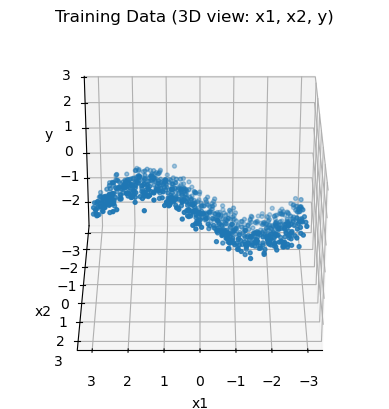

In [25]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

# 3D scatter plot of the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# X_train has two features: x1, x2
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, s=8)

ax.set_title("Training Data (3D view: x1, x2, y)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.view_init(elev=30, azim=90)
plt.show()

## 2) MLP Architecture for Regression

- **Input:** 2 features  
- **Hidden:** H units with **ReLU**  
- **Output:** 1 unit, **linear** (no activation)  
- **Loss:** **Mean Squared Error (MSE)**

We implement forward pass and backprop manually.


### **MLP for Regression — Intuitive Explanation**

#### **1. Model Architecture (What the network looks like)**

The network has **three layers**:

1. **Input layer** — takes two numbers (x₁, x₂)
2. **Hidden layer** — applies weights + bias, then ReLU
3. **Output layer** — computes the final prediction (a single number)

Flow:

```
Input → (weighted sum + bias) → ReLU → (weighted sum + bias) → Output
```

* *Weighted sum* means:
  each output is a combination of the inputs multiplied by learned weights.
* **ReLU activation** keeps only positive values and sets negatives to 0.
* The output layer has **no activation**, because regression needs any real number.

---

#### **2. Forward Pass (How the network makes predictions)**

For each training example:

1. **Hidden Layer**

   * The network mixes the two inputs using weights.
   * Adds a bias.
   * Applies ReLU (turns negative values into 0).

2. **Output Layer**

   * Takes the hidden layer values.
   * Mixes them again using new weights.
   * Adds a final bias.
   * The result is the predicted value: **ŷ**.

Think of it as:

```
1) Mix the inputs → 2) ReLU → 3) Mix again → prediction
```

---

#### **3. Loss Function (How we measure mistakes)**

We use **Mean Squared Error (MSE)**.

It simply means:

```
Take the difference between prediction and true value,
square it,
average over all samples.
```

Squared difference punishes bigger mistakes more strongly.

---

#### **4. Backpropagation (How the network learns)**

To improve itself, the network needs to know:

* “How should each weight change to reduce the error?”

Backpropagation does exactly that by:

1. Measuring how much the output changed the error.
2. Tracing this influence backward through the network.
3. Assigning credit/blame to each weight.

Layer-by-layer, the network figures out:

* Did this weight make the output too big or too small?
* Should it increase or decrease?
* By how much?

ReLU contributes by blocking negative information (if ReLU output is 0, the gradient there is also 0).

---

#### **5. Gradient Descent (How weights get updated)**

Once backprop decides the direction to change each weight:

```
new_weight = old_weight − learning_rate × gradient
```

* **Gradient** = how much this weight contributed to the error
* **Learning rate (η)** = how big a step to take when adjusting weights

The network repeats this over many “epochs,” gradually improving predictions.

---

  ```
  combine inputs → apply simple rule → adjust weights → repeat
  ```

In [3]:
# Activations
def relu(z):
    return np.maximum(0, z)
    
# derivative of relu function
def relu_grad(z):
    return (z > 0).astype(np.float32)

# Loss & metrics for regression
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    return 1 - ss_res / (ss_tot + 1e-12)

class MLPRegressor:
    def __init__(self, in_dim=2, hidden=32, out_dim=1):
        # He initialization for ReLU layer; small init for output
        self.W1 = np.random.randn(in_dim, hidden).astype(np.float32) * np.sqrt(2.0 / in_dim)
        self.b1 = np.zeros((1, hidden), dtype=np.float32)
        self.W2 = np.random.randn(hidden, out_dim).astype(np.float32) * 0.01
        self.b2 = np.zeros((1, out_dim), dtype=np.float32)
        
    def forward(self, X):
        # X shape: (N, in_dim)
        # N = number of samples, in_dim = number of input features
    
        # -------------------------------
        # Step 1: First layer (input → hidden)
        # Multiply inputs by first layer weights and add bias
        # Each neuron in the hidden layer gets a weighted sum of inputs
        z1 = X @ self.W1 + self.b1         # shape: (N, H)
    
        # -------------------------------
        # Step 2: Apply ReLU activation
        # ReLU turns negative values into 0, keeps positive ones as is
        # This makes the network nonlinear (able to bend)
        h1 = relu(z1)                      # shape: (N, H)
    
        # -------------------------------
        # Step 3: Second layer (hidden → output)
        # Multiply hidden activations by output weights and add bias
        # Since it's regression, the output is linear (no activation)
        z2 = h1 @ self.W2 + self.b2        # shape: (N, 1)
    
        # -------------------------------
        # Step 4: Identity output (no squashing)
        # The final prediction of the model
        yhat = z2                          # shape: (N, 1)
    
        # -------------------------------
        # Step 5: Save intermediate results for backward pass
        # We'll need these to compute gradients later
        cache = (X, z1, h1, z2, yhat)
    
        # Return both the prediction and the stored cache
        return yhat, cache


    def backward(self, cache, y_true):
        X, z1, h1, z2, yhat = cache
        N = X.shape[0]
        y_true = y_true.reshape(-1, 1)
    
        # -------------------------------
        # Step 1: Compute gradient of loss wrt predictions
        # For MSE: dL/dyhat = (2/N) * (yhat - y_true)
        # This tells how far our prediction was from the true value
        dL_dyhat = (2.0 / N) * (yhat - y_true)   # (N,1)
    
        # Since output layer is linear: yhat = z2
        # So gradient wrt z2 is the same
        dL_dz2 = dL_dyhat
    
        # -------------------------------
        # Step 2: Gradients for output layer weights and bias
        # dW2 = h1.T @ dL_dz2 → how much each hidden neuron contributed to error
        # db2 = mean error across all samples
        dW2 = h1.T @ dL_dz2                      # (H,1)
        db2 = dL_dz2.mean(axis=0, keepdims=True) # (1,1)
    
        # -------------------------------
        # Step 3: Backpropagate error to hidden layer
        # dh1 = dL/dz2 * W2.T → distribute output error back to hidden neurons
        dh1 = dL_dz2 @ self.W2.T                 # (N,H)
    
        # Step 4: Apply ReLU gradient
        # Only active neurons (z1 > 0) get error; others stay 0
        dz1 = dh1 * relu_grad(z1)                # (N,H)
    
        # -------------------------------
        # Step 5: Gradients for first layer weights and bias
        # dW1 = X.T @ dz1 → how inputs affected hidden errors
        # db1 = mean error per hidden neuron
        dW1 = X.T @ dz1                           # (in_dim,H)
        db1 = dz1.mean(axis=0, keepdims=True)     # (1,H)
    
        # Pack all gradients in a dictionary
        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return grads

    def step(self, grads, lr=1e-2):
        self.W1 -= lr * grads["dW1"]
        self.b1 -= lr * grads["db1"]
        self.W2 -= lr * grads["dW2"]
        self.b2 -= lr * grads["db2"]


## 3) Train the Model

We'll use mini-batch SGD with MSE loss. Track training loss per epoch and report R² on train/test at the end.


In [32]:
mlp = MLPRegressor(in_dim=2, hidden=5, out_dim=1)
epochs = 100
lr = 1e-2
batch_size = 64

loss_hist = []

N = len(X_train)
for ep in range(1, epochs+1):
    # Shuffle each epoch
    perm = np.random.permutation(N)
    X_shuf = X_train[perm]
    y_shuf = y_train[perm]

    # Mini-batches
    for i in range(0, N, batch_size):
        xb = X_shuf[i:i+batch_size]
        yb = y_shuf[i:i+batch_size]

        yhat, cache = mlp.forward(xb)
        loss = mse_loss(yb.reshape(-1,1), yhat)
        grads = mlp.backward(cache, yb)
        mlp.step(grads, lr=lr)

    # Track epoch loss on full training set
    yhat_train_full, _ = mlp.forward(X_train)
    loss_epoch = mse_loss(y_train.reshape(-1,1), yhat_train_full)
    loss_hist.append(loss_epoch)

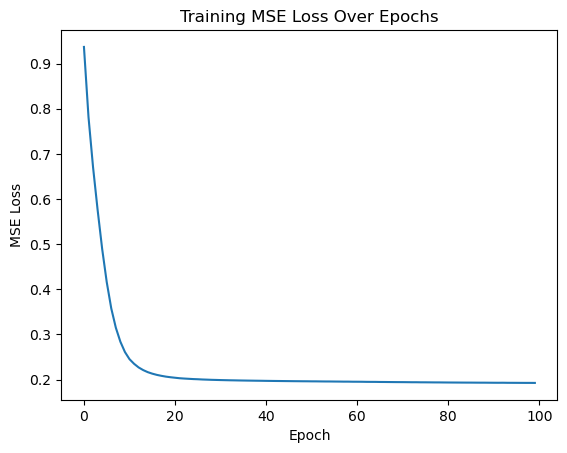

Train MSE: 0.1925
Test  MSE: 0.213
Train R^2: 0.8577
Test  R^2: 0.8184


In [33]:
# Plot training loss
plt.figure()
plt.plot(loss_hist)
plt.title("Training MSE Loss Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.show()

# Final metrics
yhat_train, _ = mlp.forward(X_train)
yhat_test,  _ = mlp.forward(X_test)

train_r2 = r2_score(y_train, yhat_train.squeeze())
test_r2  = r2_score(y_test,  yhat_test.squeeze())

print("Train MSE:", round(float(mse_loss(y_train.reshape(-1,1), yhat_train)), 4))
print("Test  MSE:", round(float(mse_loss(y_test.reshape(-1,1),  yhat_test)), 4))
print("Train R^2:", round(float(train_r2), 4))
print("Test  R^2:", round(float(test_r2), 4))

## 4) Predictions vs Targets

A good regressor should produce points close to the diagonal line in the scatter plot below.


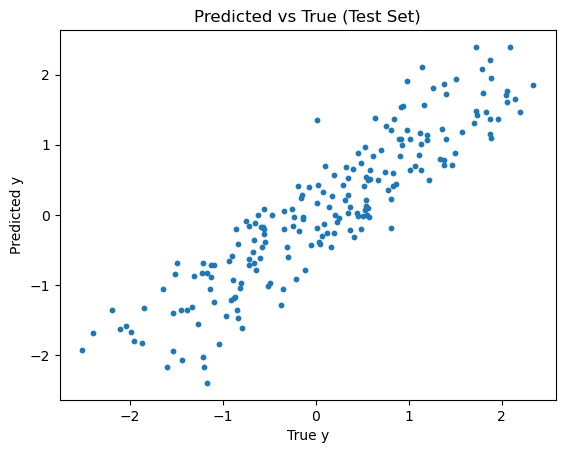

In [34]:
# Scatter: predicted vs true (test set)
plt.figure()
plt.scatter(y_test, yhat_test.squeeze(), s=10)
plt.title("Predicted vs True (Test Set)")
plt.xlabel("True y"); plt.ylabel("Predicted y")
plt.show()


## 6) Tips & Exercises

- Change hidden size (`hidden`) to see underfitting vs overfitting.  
- Try different learning rates (`1e-3`, `5e-3`, `2e-2`).  
- Add another hidden layer to increase capacity.  
- Replace ReLU with `tanh` (and consider Xavier initialization).  
- Increase noise to make the task harder.  
